In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
import numpy as np
import tensorflow as tf
import os, sys, time, pickle
from matplotlib import gridspec

import utils, optimization, metrics, plot, data, evaluation
import plot
from model import WGanModel
from gan import CosmoGAN


In [67]:
ns = 64
k = 10

# WGAN Model

In [86]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 
#time_str = '2018_3_27_13_55'

global_path = '../saved_result/'

name = 'WGAN{}'.format(ns)

bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 1]
params_discriminator['nfilter'] = [32, 32, 32, 16]
params_discriminator['shape'] = [[5, 5, 5],[5, 5, 5], [3, 3, 3], [3, 3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2, 2]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [8, 32, 64, 64, 1]
params_generator['shape'] = [[3, 3, 3], [3, 3, 3], [5, 5, 5], [5, 5, 5], [5, 5, 5]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['full'] = [2*2*2*8]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 8
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.0
params_optimization['beta2'] = 0.9
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params_cosmology = dict()
params_cosmology['clip_max_real'] = False
params_cosmology['log_clip'] = 0.1
params_cosmology['sigma_smooth'] = 1
params_cosmology['k'] = k
params_cosmology['Npsd'] = 50
params_cosmology['max_num_psd'] = 100

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 2
params['viz_every'] = 2
params['save_every'] = 2
params['print_every'] = 2
params['name'] = name
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'

# 64x64x64 Gaussian Data

In [115]:
params['save_dir'] = '../64_by_64_synthetic_result/WGAN64_2018_3_19_16_8checkpoints/'
wgan = CosmoGAN(params, WGanModel, is_3d=True)

nsamples = 16
fake_gaus, fake_gaus_raw = wgan.generate(N=nsamples)
fake_gaus = np.squeeze(fake_gaus)
fake_gaus_raw = np.squeeze(fake_gaus_raw)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 64 outputs
         Size of the variables: (?, 64)
     Reshape to (?, 2, 2, 2, 8)
     1 Deconv layer with 8 channels
         Size of the variables: (?, 4, 4, 4, 8)
     2 Deconv layer with 32 channels
         Size of the variables: (?, 8, 8, 8, 32)
     3 Deconv layer with 64 channels
         Size of the variables: (?, 16, 16, 16, 64)
     4 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 32, 64)
     5 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 64, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 64, 64, 64, 1)
     0 Conv layer with 32 channels
         Size of the variables: (?, 32, 32, 32, 32)
     1 Conv 

In [143]:
dataset, real_gaus_raw = data.load.load_3d_synthetic_samples(nsamples = nsamples,dim=ns, k=k)

real_gaus = dataset.get_all_data()
print("Gaussian dataset shape: ", np.shape(real_gaus))

Gaussian dataset shape:  (16, 64, 64, 64)


### Display Real and Fake Samples

64x64x64 Gaussian Data
REAL SAMPLES                                               FAKE SAMPLES


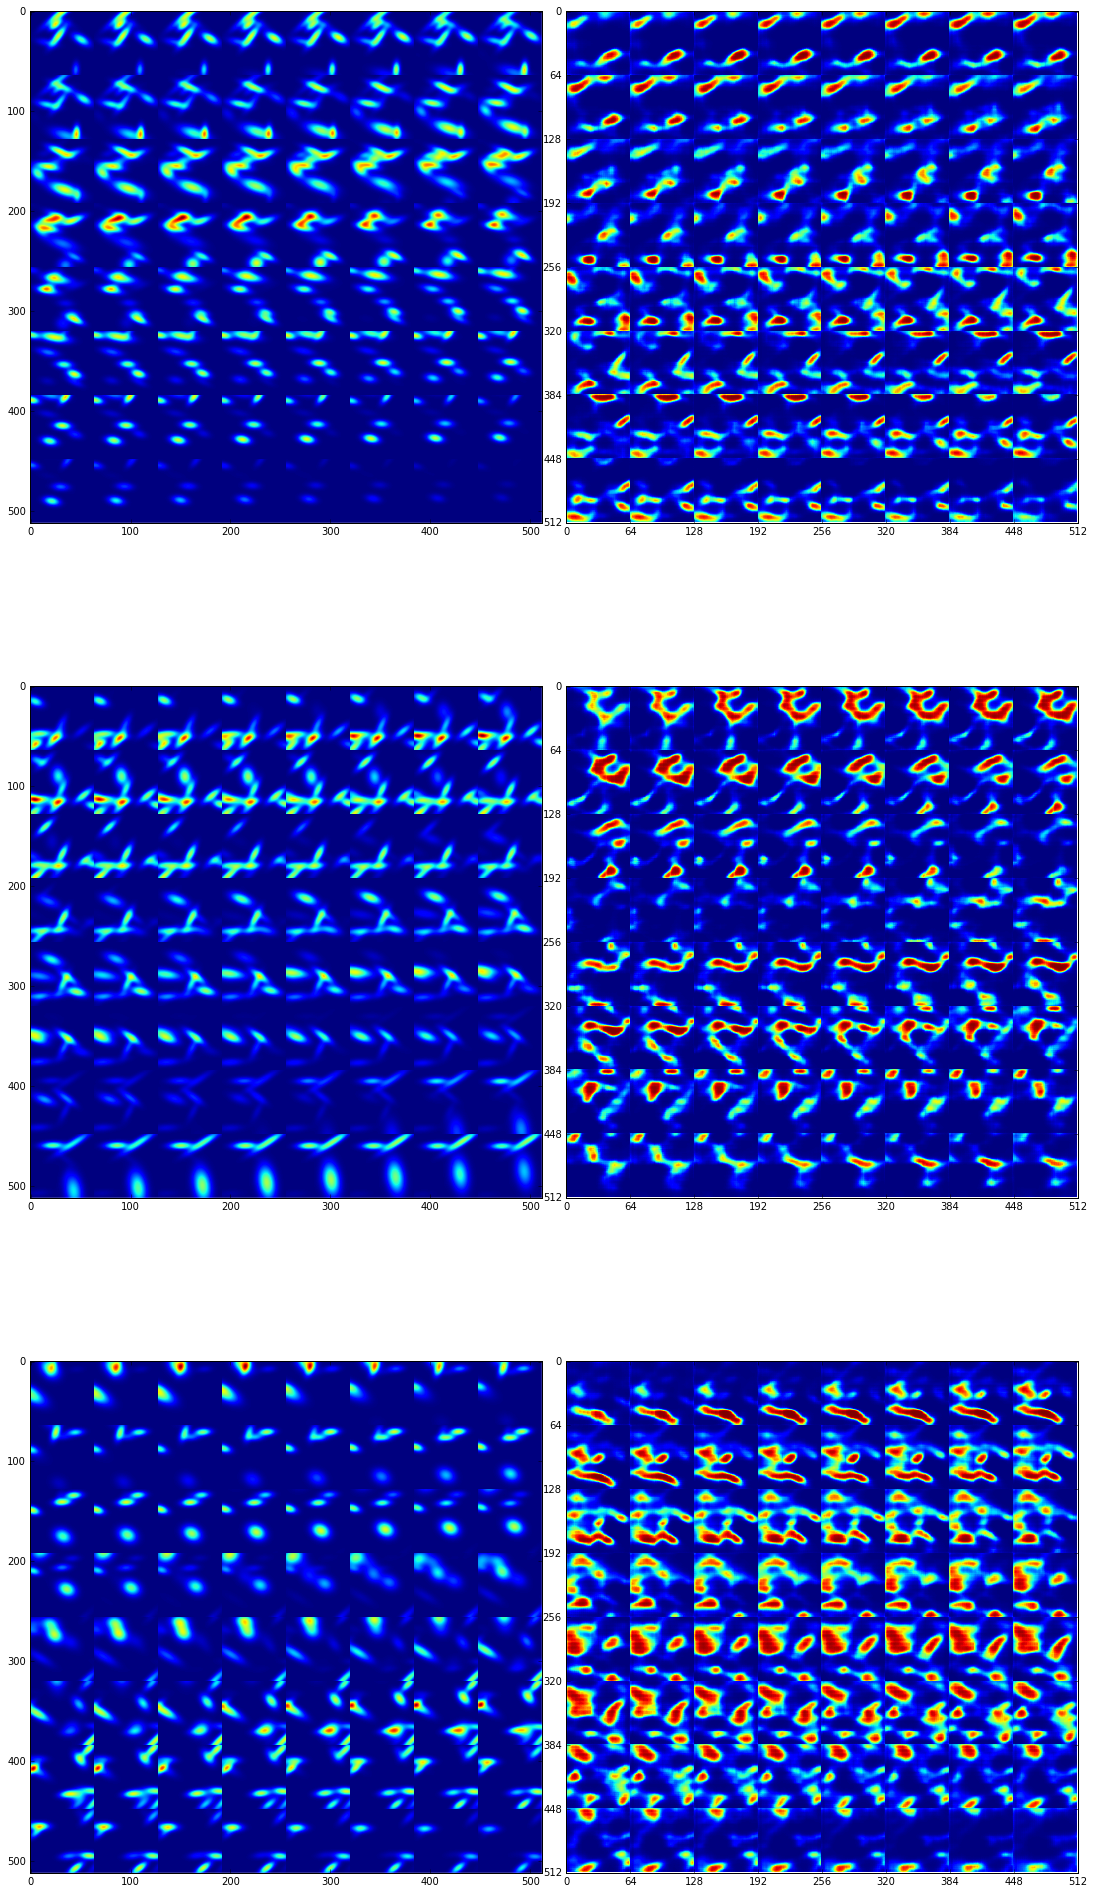

In [144]:
print('64x64x64 Gaussian Data')
print('REAL SAMPLES                                               FAKE SAMPLES')
fig = plt.figure(figsize=(15,150))

for i in range(3):
    
    ax_real = plt.subplot2grid((nsamples, 2), (i, 0) )
    plot.tile_and_plot_3d_image(ax_real, real_gaus[i,:, :, :])
    
    ax_fake = plt.subplot2grid((nsamples, 2), (i, 1) )
    plot.tile_and_plot_3d_image(ax_fake, fake_gaus[i,:, :, :])
    
    plt.xticks(np.arange(0, 513, 64))
    plt.yticks(np.arange(0, 513, 64))
    
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

### Display Real and Fake PSDs, Peak Counts, Mass Histogram

Log l2 PSD loss: 129.97697871904998
L2 PSD loss: 56452065288.75703
Log l1 PSD loss: 9.27025400059959
L1 PSD loss: 133064.0055345538


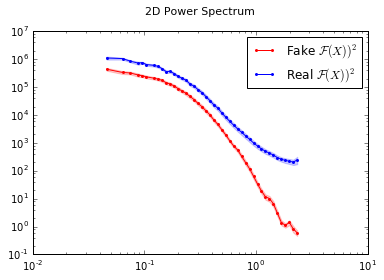

In [145]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(real_gaus_raw, fake_gaus_raw, is_3d=True)

Log l2 Peak Count loss: 229.9775339996163
L2 Peak Count loss: 191336.84765625
Log l1 Peak Count loss: 8.017308633850798
L1 Peak Count loss: 98.71875


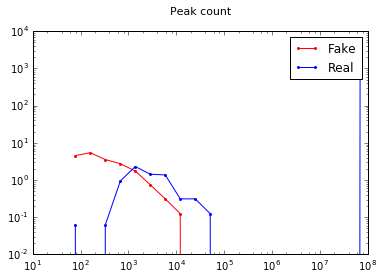

In [127]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_gaus_raw, fake_gaus_raw)

Log l2 Mass histogram loss: 222.32400611587818
L2 Peak Mass histogram: 7560576.458203125
Log l1 Mass histogram loss: 7.948176220576963
L1 Mass histogram loss: 1253.675


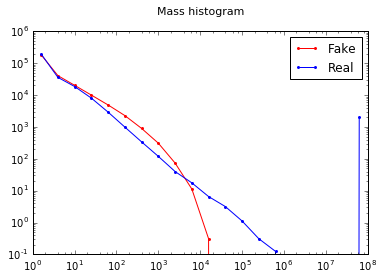

In [128]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_gaus_raw, fake_gaus_raw)

# 64x64x64 Nbody Data

In [129]:
params['save_dir'] = '../64_by_64_nbody_result/WGAN64_2018_3_25_5_21checkpoints/'
wgan = CosmoGAN(params, WGanModel, is_3d=True)

nsamples = 16
fake_nbody, fake_nbody_raw = wgan.generate(N=nsamples)
fake_nbody = np.squeeze(fake_nbody)
fake_nbody_raw = np.squeeze(fake_nbody_raw)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 64 outputs
         Size of the variables: (?, 64)
     Reshape to (?, 2, 2, 2, 8)
     1 Deconv layer with 8 channels
         Size of the variables: (?, 4, 4, 4, 8)
     2 Deconv layer with 32 channels
         Size of the variables: (?, 8, 8, 8, 32)
     3 Deconv layer with 64 channels
         Size of the variables: (?, 16, 16, 16, 64)
     4 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 32, 64)
     5 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 64, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 64, 64, 64, 1)
     0 Conv layer with 32 channels
         Size of the variables: (?, 32, 32, 32, 32)
     1 Conv 

In [138]:
dataset =  data.load.load_3d_dataset(spix=ns)
real_nbody = dataset.get_samples(N=nsamples)
real_nbody_raw = utils.backward_map(real_nbody)
print("Nbody dataset shape: ", np.shape(real_nbody))

Nbody dataset shape:  (16, 64, 64, 64)


### Display Real and Fake Samples

64x64x64 Nbody Data
REAL SAMPLES                                               FAKE SAMPLES


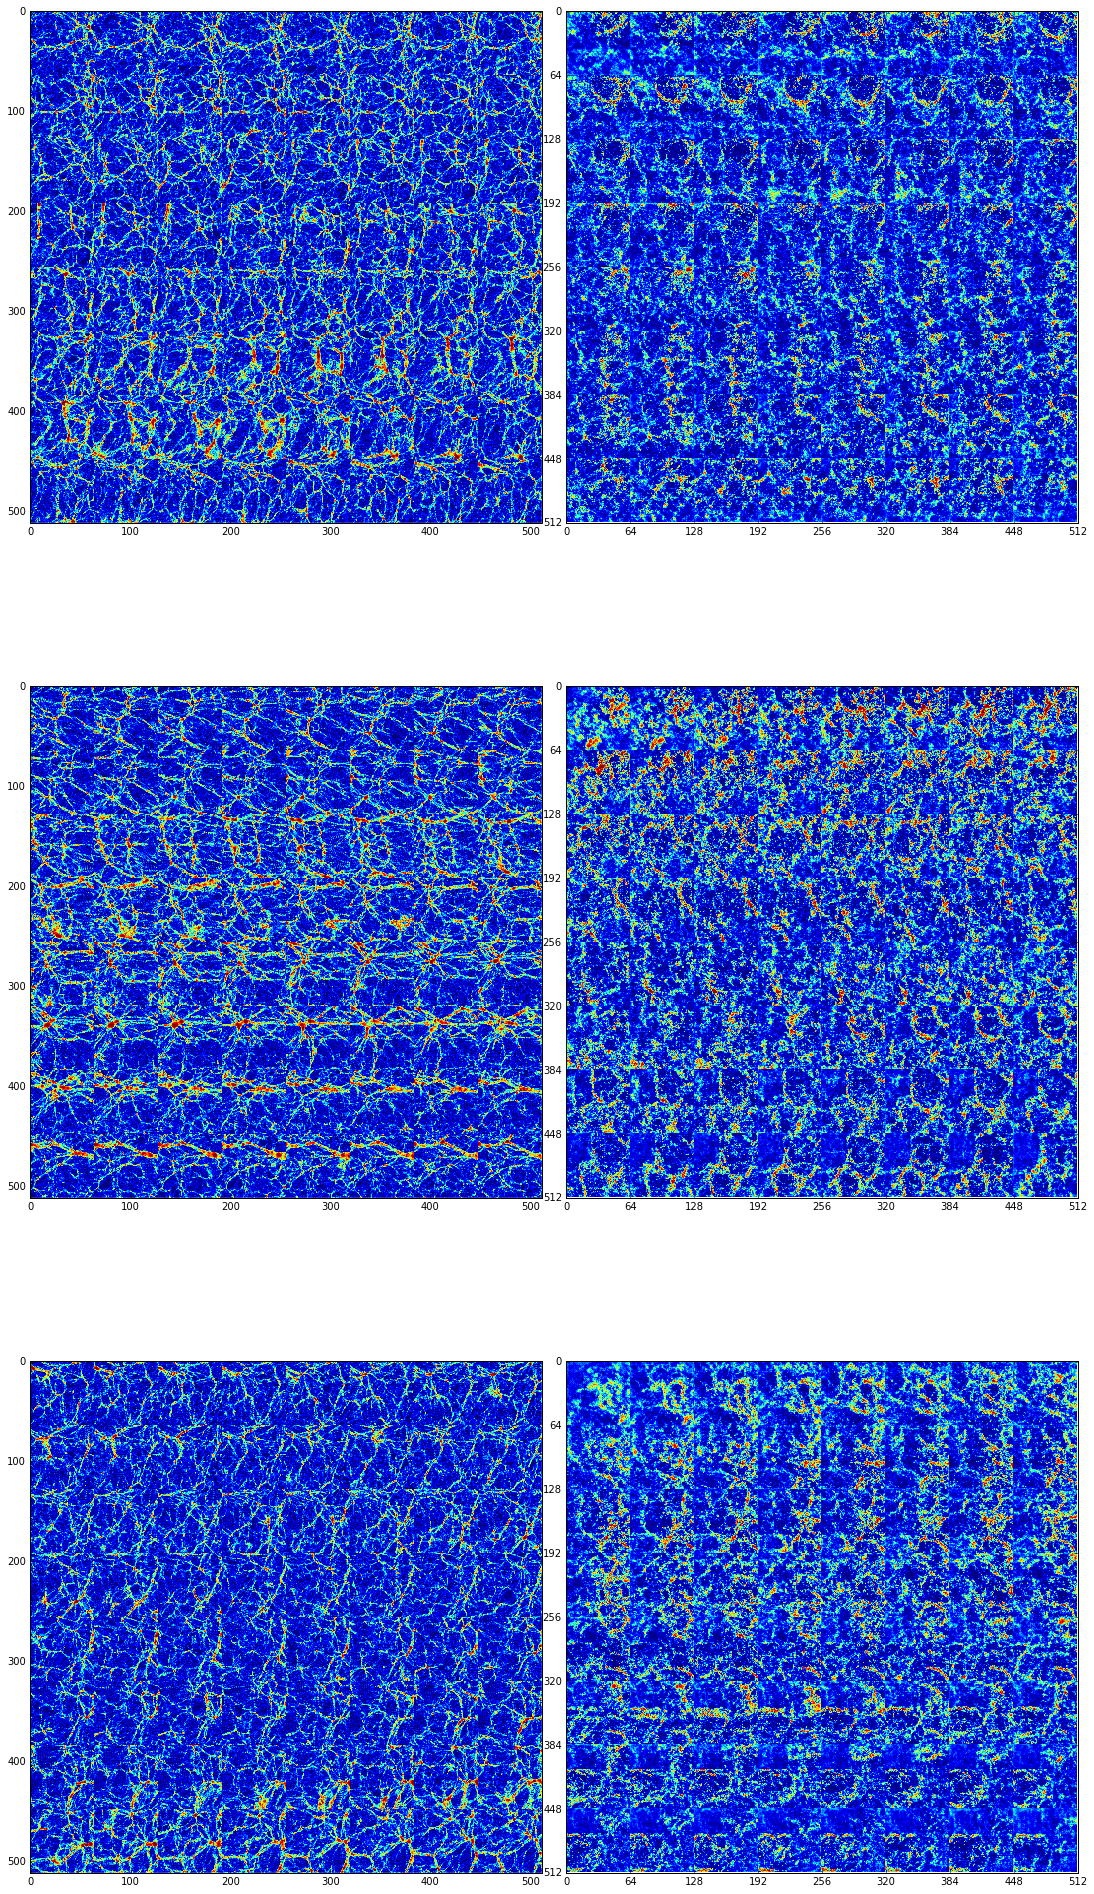

In [133]:
print('64x64x64 Nbody Data')
print('REAL SAMPLES                                               FAKE SAMPLES')
fig = plt.figure(figsize=(15,150))

for i in range(3):
    
    ax_real = plt.subplot2grid((nsamples, 2), (i, 0) )
    plot.tile_and_plot_3d_image(ax_real, real_nbody[i,:, :, :])
    
    ax_fake = plt.subplot2grid((nsamples, 2), (i, 1) )
    plot.tile_and_plot_3d_image(ax_fake, fake_nbody[i,:, :, :])
    
    plt.xticks(np.arange(0, 513, 64))
    plt.yticks(np.arange(0, 513, 64))
    
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

### Display Real and Fake PSDs, Peak Counts, Mass Histogram

Log l2 PSD loss: 36.56609179629877
L2 PSD loss: 528538952.3773983
Log l1 PSD loss: 5.022037906872703
L1 PSD loss: 14926.516079803228


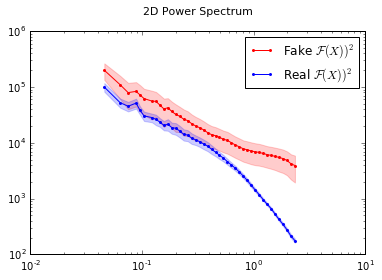

In [142]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(real_nbody_raw, fake_nbody_raw, is_3d=True)

Log l2 Peak Count loss: 25.961771895603288
L2 Peak Count loss: 1410.076171875
Log l1 Peak Count loss: 3.0246769168461993
L1 Peak Count loss: 23.2


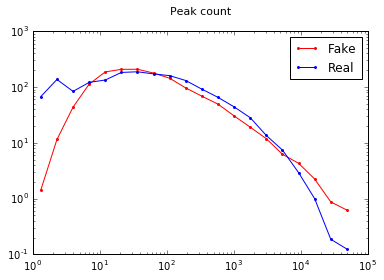

In [136]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_nbody_raw, fake_nbody_raw)

Log l2 Mass histogram loss: 11.944236325673476
L2 Peak Mass histogram: 144493818.99609375
Log l1 Mass histogram loss: 1.817943951516071
L1 Mass histogram loss: 4541.0


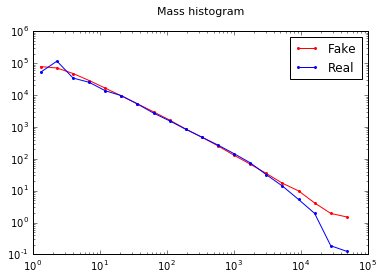

In [137]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_nbody_raw, fake_nbody_raw)